<a href="https://colab.research.google.com/github/cralji/Deep_Krein_RF/blob/main/Krein_Cat_dogs_Keras_Tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminares

## Intalar Paquetes Necesarios

In [1]:
%%capture
!pip install --upgrade keras==2.15.0
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git >> /tmp/null

In [2]:
%%capture
!pip install keras-tuner

In [3]:
%%capture
!git clone https://github.com/cralji/Deep_Krein_RF.git

## Incorporando Repo al PATH

In [4]:
import os
import sys

sys.path.append('/content/Deep_Krein_RF')

os.chdir('/content/Deep_Krein_RF')

## Cambiando KErnel del proceso Gaussiado de la Optimización Bayesiana dek KerasTuner a un Matern$_{\nu=\frac{1}{2}}$

In [5]:
import keras_tuner
import os

# Get the directory where keras_tuner is installed
keras_tuner_dir = os.path.dirname(keras_tuner.__file__)

# Construct the path to bayesian.py
bayesian_path = os.path.join(keras_tuner_dir, 'src', 'tuners', 'bayesian.py')

with open("cambio_matern_12.txt", "r") as f:
  new_content = f.read()
  # print(new_content)

with open(bayesian_path, 'w') as file:
  file.write(new_content)

# print(new_content)

In [6]:
import keras_tuner
import os

# Get the directory where keras_tuner is installed
keras_tuner_dir = os.path.dirname(keras_tuner.__file__)

# Construct the path to bayesian.py
bayesian_path = os.path.join(keras_tuner_dir, 'src', 'tuners', 'bayesian.py')

print(bayesian_path)

/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/bayesian.py


#Proceso

## Cargue Librerias

In [7]:
from krein_functions import *
from models import krein_rff_unet
from metrics import DiceCoefficient
from losses import WeightedDiceLoss
from callbacks import MetricsCallback

# General Libraries
import time
import shutil
import random
import warnings
import pandas as pd
import seaborn as sns
from enum import auto, Enum
from functools import partial
from datetime import datetime

# Image Processing Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.cm import coolwarm

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras_tuner import Objective
from keras_tuner import HyperModel
import tensorflow.keras.backend as K
from keras.layers import Layer, Activation
from keras_tuner import BayesianOptimization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import get_custom_objects
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Machine Learning Libraries - Sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, DotProduct, ExpSineSquared, Matern

# Deep Learning Libraries - GCPDS
from gcpds.image_segmentation.datasets.segmentation import OxfordIiitPet

# Deep Learning Libraries - TensorFlow specific
# from tensorflow.keras.losses import Loss
# from tensorflow.keras.metrics import Metric
from tensorflow.keras import Model, layers, regularizers

# Other Libraries
import gc
import json
import gdown
import itertools
from PIL import ImageFont
from dataclasses import dataclass
from matplotlib.style import available
from tensorflow.python.framework.ops import EagerTensor

warnings.filterwarnings("ignore") # Disable warnings

## Load Dataset

In [8]:
dataset = OxfordIiitPet()
train_dataset, val_dataset, test_dataset = dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.PPM9S2_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.PPM9S2_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [9]:
def preprocess(img,mask):
    img = tf.image.resize(img,(256,256))
    mask = tf.image.resize(mask,(256,256))#Ch 1: Seed, Ch 2: No germinate, Ch 3: germinate
    mask = tf.cast(mask>0, tf.float32)
    mask = mask[...,1]
    mask = mask[...,tf.newaxis]
    # mask_ = tf.reduce_sum(mask, axis =[-1], keepdims=True)
    back_ground = tf.reduce_sum(mask, axis =[-1], keepdims=True)
    back_ground = back_ground == 0
    back_ground = tf.cast(back_ground, tf.float32)
    mask = tf.concat([mask,back_ground], axis=-1) #Ch 1: No germinate, Ch 2: germinate, Ch 3: Background
    return img,mask

train = train_dataset.map(lambda x,y,label,id:preprocess(x,y))
train = train.batch(64)
train = train.cache()


val = val_dataset.map(lambda x,y,label,id:preprocess(x,y))
val = val.batch(64)
val = val.cache()

In [10]:
def build_model(hp:HyperParameters):

  # parameters
  learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')
  phi_units = hp.Int('phi_units', min_value=2, max_value=8, step=2)

  # Build model
  model = krein_rff_unet((256,256,3),2,phi_units=phi_units)
  optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate)
  model.compile(loss = WeightedDiceLoss(weights=[0.5,0.5]),
                optimizer=optimizer,
                metrics=[DiceCoefficient(name='dice_cat_dog',target_class=0),
                         DiceCoefficient(name='dice_background',target_class=1),
                         DiceCoefficient(name = 'dice')
                        ]
                  )
  return model

In [16]:
from tensorflow.keras.callbacks import Callback

class MetricsCallback(Callback):
    """
    Custom Keras callback to log metrics at the end of training epochs.

    This callback logs metrics such as loss and accuracy at the end of each epoch
    during training. It stores the metrics in a global list `global_metrics` upon
    completion of the final epoch.

    Parameters:
        epochs (int): Total number of epochs for training.

    Methods:
        on_epoch_end(epoch, logs=None):
            Called at the end of each epoch. Logs metrics and stores them in
            `global_metrics` upon completion of the final epoch.
    """

    def __init__(self, epochs):
        """
        Initializes the MetricsCallback instance.

        Parameters:
            epochs (int): Total number of epochs for training.
        """
        super().__init__()
        self.epochs = epochs

    def on_epoch_end(self, epoch, logs=None):
        """
        Callback function called at the end of each epoch.

        Logs metrics such as loss and accuracy at the end of each epoch.
        Stores the metrics in `global_metrics` upon completion of the final epoch.

        Parameters:
            epoch (int): Current epoch number (0-indexed).
            logs (dict): Dictionary containing the metrics to log.
                Typically contains keys like 'loss' and 'accuracy'.
        """
        if epoch == self.epochs - 1:
            print(f"Final Epoch {epoch + 1}:")
            metrics_dict = {'epoch': epoch + 1}
            for key, value in logs.items():
                print(f"{key}: {value:.4f}")
                metrics_dict[key] = value
            global_metrics.append(metrics_dict)

In [17]:
num_epochs = 10
global_metrics = []
callbacks = [MetricsCallback(num_epochs)]

In [18]:
# Define HyperModel and tuner
tuner = BayesianOptimization(build_model,
                             objective=Objective('val_loss',direction='min'),
                             max_trials=30,
                             executions_per_trial=1,
                             directory='../my_dir',
                             project_name='loss_dice')

Reloading Tuner from ../my_dir/loss_dice/tuner0.json


In [19]:
# Fit the tuner
tuner.search(train, epochs=num_epochs, validation_data=val, callbacks=callbacks)

Trial 30 Complete [00h 01m 00s]
val_loss: 88.38343048095703

Best val_loss So Far: -245.71136474609375
Total elapsed time: 00h 37m 27s


In [31]:
tuner.oracle.gpr.kernel_

Matern(length_scale=1e-05, nu=2.5)

In [35]:
gp = tuner.oracle.gpr # tuner.oracle._gpr_trained()
print(f"Kernel parameters before training: {gp.kernel}\nKernel parameters after training: {gp.kernel_}")

Kernel parameters before training: Matern(length_scale=1, nu=2.5)
Kernel parameters after training: Matern(length_scale=1e-05, nu=2.5)


In [45]:
trial.hyperparameters.values

{'learning_rate': 0.03395824256029711, 'phi_units': 8}

In [47]:
# Convert to a pandas data frame the metrics of each epoch of each trial
df_metrics = pd.DataFrame(global_metrics)

# List to store the results
trial_results = []

# Iterate over all trials
for trial in tuner.oracle.get_best_trials(num_trials=tuner.oracle.max_trials):
    trial_info = {
        'trial_id': trial.trial_id,
        'hyperparameters': trial.hyperparameters.values,
        # 'loss': trial.metrics.get_best_value('val_loss')
    }
    trial_results.append(trial_info)

# Convert the results list to a DataFrame
df_trials = pd.DataFrame(trial_results)

# Apply pd.json_normalize to expand the dictionary into new columns
df_hyperparameters = pd.json_normalize(df_trials['hyperparameters'])

# Combine the original DataFrame with the new hyperparameter columns
# hp_df = pd.concat([df_trials['trial_id'], df_hyperparameters, df_trials['loss'], df_metrics['dice']], axis=1)
hp_df = pd.concat([df_trials['trial_id'], df_hyperparameters, df_metrics['dice']], axis=1)


# Display the combined DataFrame
hp_df = hp_df.sort_values(by='trial_id')
hp_df.to_json('hp_df.json')
hp_df

,trial_id,learning_rate,phi_units,dice
28,00,0.033958,8,NaN
29,01,0.020418,2,NaN
17,02,0.009011,6,0.752924
16,03,0.004020,4,0.716817
5,04,0.030952,2,0.762506
27,05,0.003585,8,0.696974
3,06,0.042075,8,0.738901
6,07,0.000601,8,0.700399
21,08,0.093331,4,0.706565
20,09,0.001505,6,0.718527


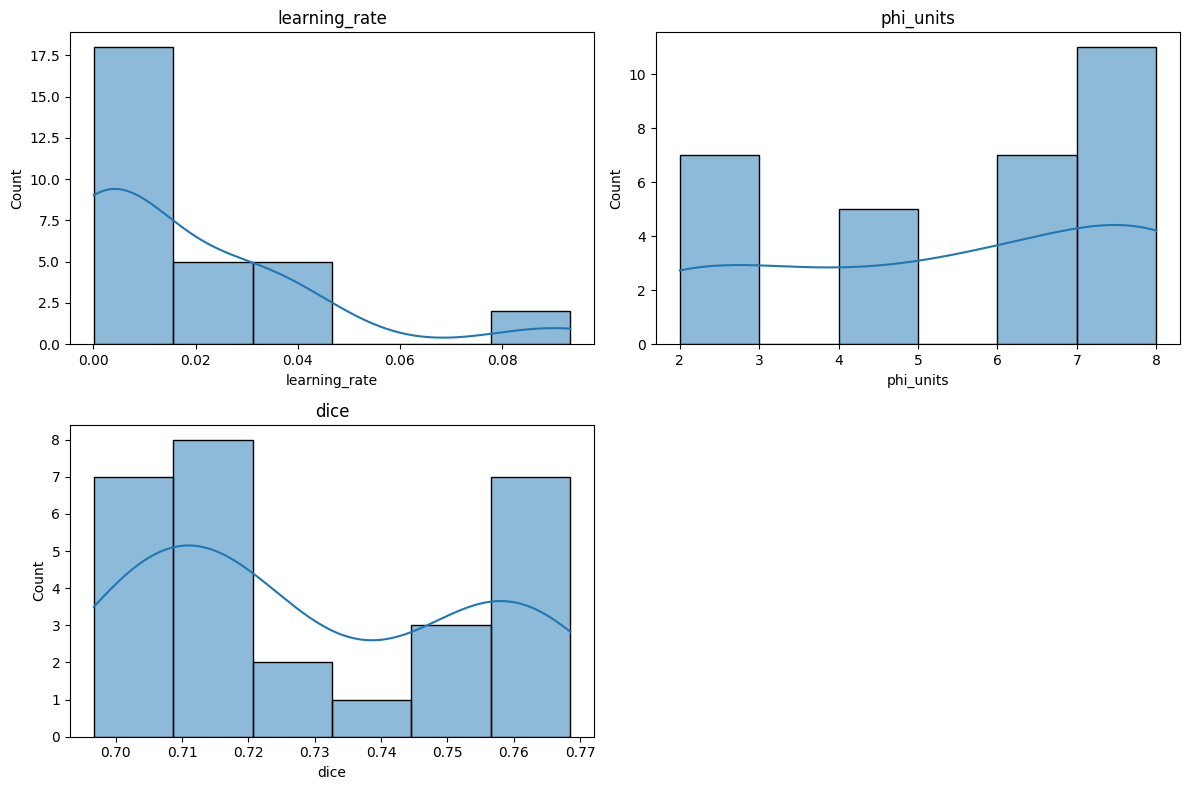

In [48]:
# Plots the distributions
plt.figure(figsize=(12, 8))
for i, column in enumerate(hp_df.columns[1:]):
    plt.subplot(2, 2, i+1)
    sns.histplot(hp_df[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

KeyError: 'loss'

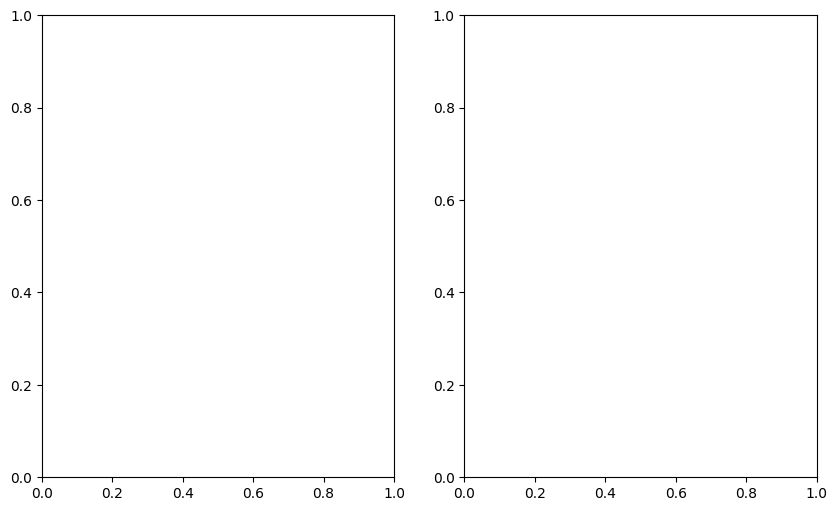

In [49]:
columns_to_log_scale = ['learning_rate']
# Plot hyperparameters values vs loss value
fig,axes = plt.subplots(1, 2, figsize=(10, 6))

# Iterate over each subplot and the corresponding scatterplot is created.
for (column, ax) in zip(hp_df.iloc[:, 1:4], axes.flatten()):
    sns.scatterplot(x=hp_df[column], y=hp_df['loss'], hue=hp_df['loss'], palette='viridis', ax=ax, legend=False)
    ax.set_xlabel(column)
    if hp_df[column].name in columns_to_log_scale:
        ax.set_xscale('log')
    ax.set_ylabel('Loss value')
    ax.set_title(f'{column} vs Loss value')

# Adjust the design and show the figure
plt.tight_layout()
plt.show()

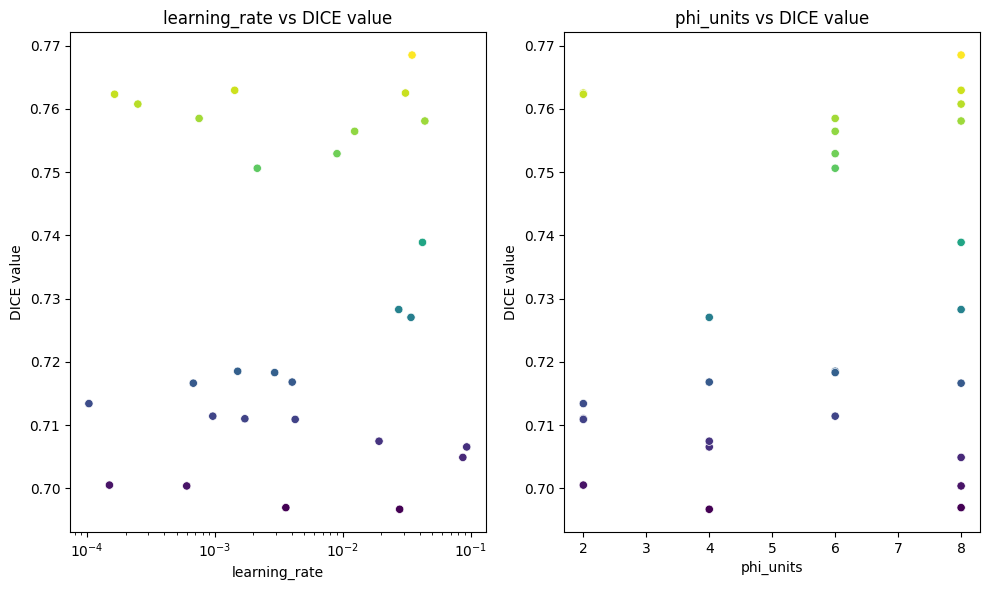

In [50]:
columns_to_log_scale = ['learning_rate']
# Plot hyperparameters values vs loss value
fig,axes = plt.subplots(1, 2, figsize=(10, 6))

# Iterate over each subplot and the corresponding scatterplot is created.
for (column, ax) in zip(hp_df.iloc[:, 1:4], axes.flatten()):
    sns.scatterplot(x=hp_df[column], y=hp_df['dice'], hue=hp_df['dice'], palette='viridis', ax=ax, legend=False)
    ax.set_xlabel(column)
    if hp_df[column].name in columns_to_log_scale:
        ax.set_xscale('log')
    ax.set_ylabel('DICE value')
    ax.set_title(f'{column} vs DICE value')

# Adjust the design and show the figure
plt.tight_layout()
plt.show()

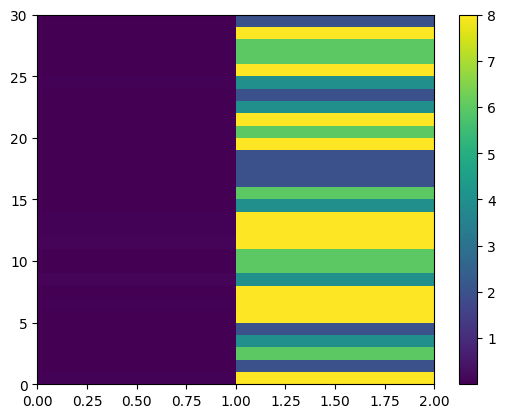

KeyError: 'loss'

In [51]:
# Plot a heatmap of the learning rate and q hyperparameters
plt.pcolormesh(hp_df[['learning_rate', 'phi_units']].values)
plt.colorbar()  # Add a colorbar
plt.show()

# Plot the loss values over trials
plt.plot(hp_df['loss'].values, label='Loss', linestyle='-', color='blue')

# Plot the dice metric values over trials
plt.plot(hp_df['dice'].values, label='Dice Metric', linestyle='-', color='orange')

# Add a legend to differentiate between the loss and dice metric plots
plt.legend()

# Display the line plots
plt.show()

In [52]:
# Call the _vectorize_trials method from the tuner oracle
# This method converts the hyperparameter configurations of trials into vector representations (X)
# and pairs these vectors with their corresponding performance scores (y)
X, y = tuner.oracle._vectorize_trials()

# Generate 300 points evenly spaced between the minimum and maximum values of the first feature in X
# Add a small buffer (0.00003) to the minimum and maximum to avoid edge effects
hp_1 = np.linspace(X[:,0].min() - 0.00003, X[:,0].max() + 0.00003, 300)

# Generate 300 points evenly spaced between the minimum and maximum values of the second feature in X
# Add a small buffer (0.00003) to the minimum and maximum to avoid edge effects
hp_2 = np.linspace(X[:,1].min() - 0.00003, X[:,1].max() + 0.00003, 300)

In [53]:
# Create a meshgrid for the input space
Xx, Yy = np.meshgrid(hp_1, hp_2)

# Stack the meshgrid arrays to create the input for prediction
XY = np.vstack([Xx.ravel(), Yy.ravel()]).T

# Make predictions using the Gaussian Process model
mean, std = gp.predict(XY, return_std=True)

# Reshape the predictions to match the shape of the meshgrid
mean = mean.reshape(Xx.shape)
std = std.reshape(Xx.shape)

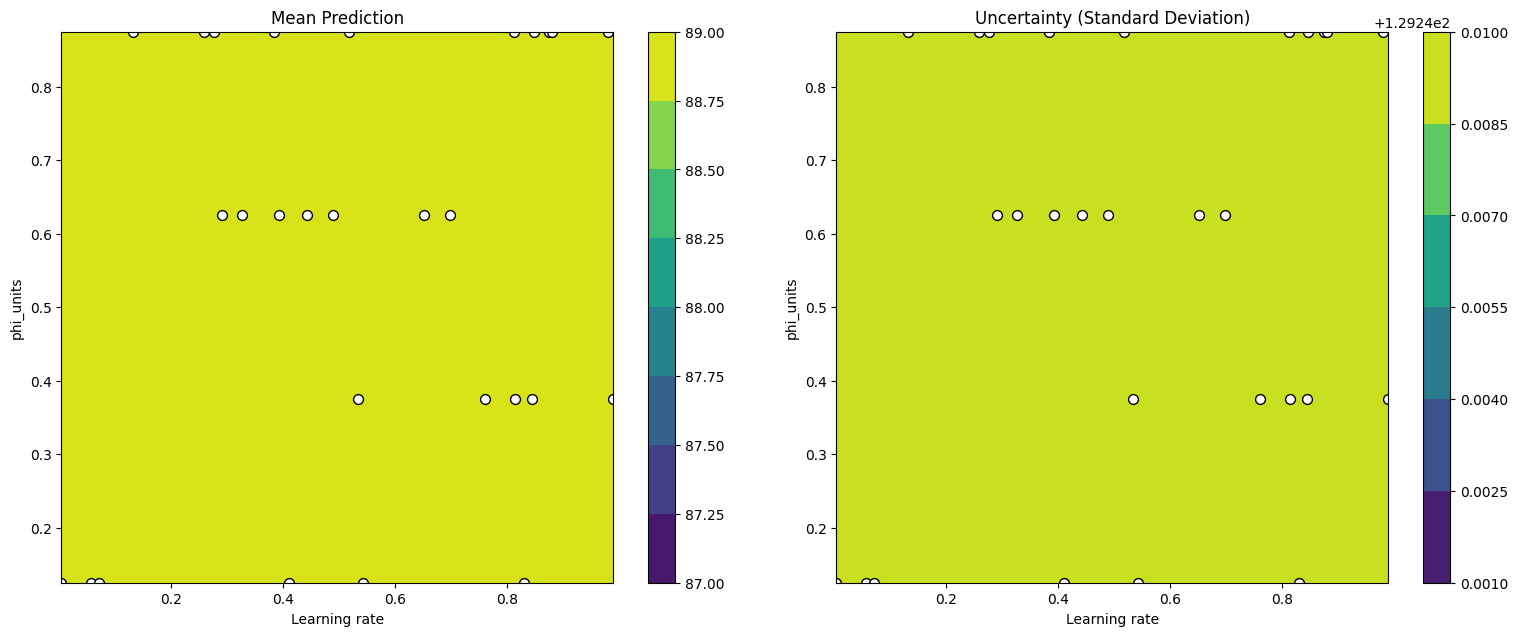

In [54]:
# Plot the results
plt.figure(figsize=(16, 7))

# Heatmap of the mean prediction
plt.subplot(1, 2, 1)
plt.title('Mean Prediction')
plt.xlabel('Learning rate')
plt.ylabel('phi_units')
# Plot the heatmap of the mean prediction using contourf
heatmap1 = plt.contourf(hp_1, hp_2, mean, cmap='viridis', aspect='auto')  # Adjust the axis scaling
plt.colorbar(heatmap1)  # Add a colorbar
plt.scatter(X[:, 0], X[:, 1], c='white', s=50, edgecolors='k') # Scatter plot of the data points in white with black edges

# Heatmap of the uncertainty (standard deviation)
plt.subplot(1, 2, 2)
plt.title('Uncertainty (Standard Deviation)')
plt.xlabel('Learning rate')
plt.ylabel('phi_units')
# Plot the heatmap of the standard deviation using contourf
heatmap2 = plt.contourf(hp_1, hp_2, std, cmap='viridis', aspect='auto')  # Adjust the axis scaling
plt.colorbar(heatmap2)  # Add a colorbar
plt.scatter(X[:, 0], X[:, 1], c='white', s=50, edgecolors='k') # Scatter plot of the data points in white with black edges

# Adjust the spacing between subplots to prevent overlap
plt.tight_layout(pad=3.0)
# Display the plots
plt.show()

# Guardar en Repo GitHub

In [55]:
# path_token = "/content/drive/MyDrive/____UTP/tokens/token_colab.py"
# # Lee el token de tu Google Drive
# with open(path_token, 'r') as token_file:
#     token = token_file.read().strip()

# # Configura el comando git para usar el token
# os.system("git config --global user.email 'craljimenez@utp.edu.co'")
# os.system("git config --global user.name 'Cristian Jimenez Colab'")
# os.system(f"git remote set-url origin https://{token}@github.com/cralji/Deep_Krein_RF.git")

0

In [57]:

# Hacer commit y push de los cambios
# !git add .
# !git commit -m "Se Corrige paquetes no introducidos en losses.py"
# !git push origin main

# # Hacer pull de los cambios remotos
# !git pull origin main

[main 968ca5f] Se Corrige paquetes no introducidos en losses.py
 7 files changed, 8 insertions(+)
 rewrite __pycache__/losses.cpython-310.pyc (76%)
 create mode 100644 hp_df.json
Enumerating objects: 14, done.
Counting objects: 100% (14/14), done.
Delta compression using up to 12 threads
Compressing objects: 100% (10/10), done.
Writing objects: 100% (10/10), 10.94 KiB | 5.47 MiB/s, done.
Total 10 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/cralji/Deep_Krein_RF.git
   4411790..968ca5f  main -> main


In [56]:
# !git status


On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   __pycache__/callbacks.cpython-310.pyc
	modified:   __pycache__/krein_functions.cpython-310.pyc
	modified:   __pycache__/losses.cpython-310.pyc
	modified:   __pycache__/metrics.cpython-310.pyc
	modified:   __pycache__/models.cpython-310.pyc
	modified:   metrics.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	hp_df.json

no changes added to commit (use "git add" and/or "git commit -a")
